In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [6]:
%load_ext autoreload
%autoreload 2
import cProfile
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import shutil
import yaml
from rdkit import RDLogger
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

def execute_yaml(yaml_path: str) -> MCTS:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    logger = make_logger(output_dir, file_level=logging.DEBUG)

    transition_conf = conf.get("transition_conf", {})
    if "model_dir" in transition_conf:
        transition_conf["model_dir"] = os.path.join(repo_root, transition_conf["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_conf["model_dir"])) + ".lang"
        lang_path = add_sep(transition_conf["model_dir"]) + lang_name
    lang = Language.load(lang_path, device=conf.get("device"))
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, **transition_conf)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_conf", {}))
    policy_class = class_from_package("policy", conf.get("policy_class"))
    policy = policy_class(**conf.get("policy_conf", {}))

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))
        
    root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization
    generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=output_dir, logger=logger, **conf.get("generator_conf", {}))

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)

    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    # cProfile.run("generator.generate(root=root, **generation_conf)"")
    generator.plot(**conf.get("plot_conf", {}))
    generator.analyze()
    
    return generator, conf

def queue_yaml(*args: str):
    for yaml_path in args:
        execute_yaml(yaml_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Is CUDA available: False
Starting generation...
1- time: 0.00, reward: 0.29199875053101465, node: COc1cccc([C@@H]2C(=O)N(c3cncnc3-n3ccnn3)C2)c1
2- time: 0.00, reward: 0.17446714091760032, node: CC(C)n1cnc(-c2ccc(Cl)c(OCC(F)(F)F)c2)n1
3- time: 0.42, reward: 0.3139607164946796, node: O=C(Nc1cccc(F)c1)c1ccc(C(F)(F)F)cc1
4- time: 0.72, reward: 0.4664994479622818, node: NC(=O)c1ccc(NC(=O)[C@H]2CCCCO2)cc1
5- time: 0.98, reward: 0.2891230622420085, node: Fc1nc(N2CCN(Cc3cccc(F)c3)CC2)nc2ccc(Cl)cc21
6- time: 1.25, reward: 0.0, node: [NH3+][C@H](Cc1ccc(F)cc1)C1(C#N)CCC1
7- time: 1.25, reward: 0.42307081502753685, node: [NH3+]C[C@@H]1CCCC[C@@H]1NC(=O)c1ccc(F)cc1
8- time: 1.50, reward: 0.41173818550174146, node: c1ccc(N[C@H]2CC[C@@H](NC(=O)NCc3ccccc3)C2)nn1
9- time: 1.80, reward: 0.3321736766386105, node: Clc1cccc(F)c1N[C@@H]1CCS[C@H]1C(=O)[O-]
10- time: 1.80, reward: 0.15925619927916432, node: Clc1ccccc1Nc1cc(N2CCC2)oc1C
11- time: 1.80, reward: 0.30589985601617525, node: Clc1cccc(OCc2nc(SCCc3cccs

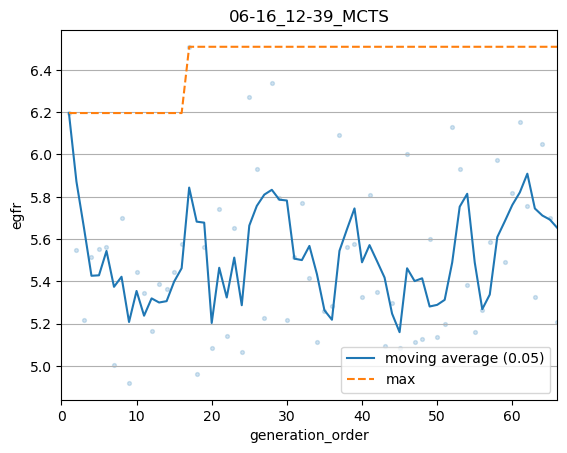

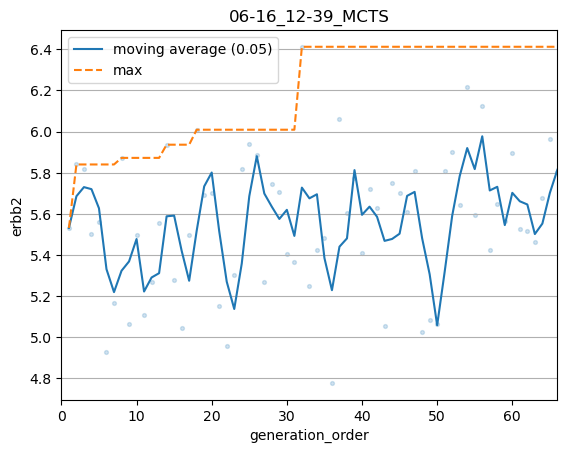

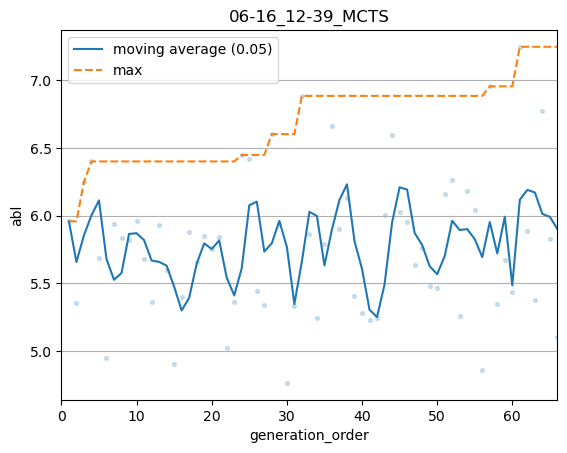

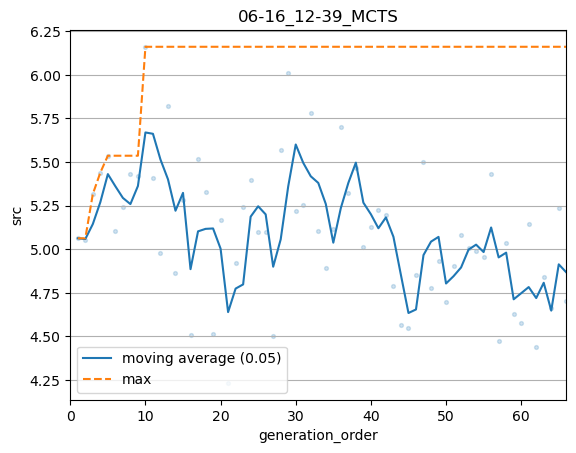

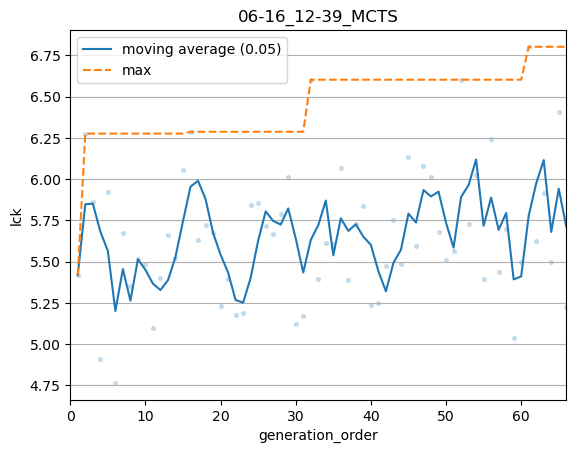

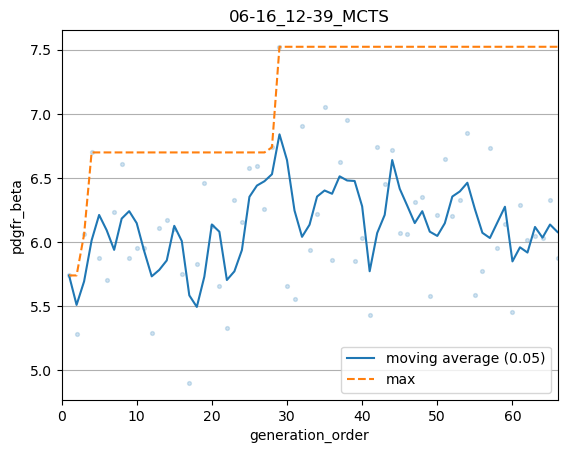

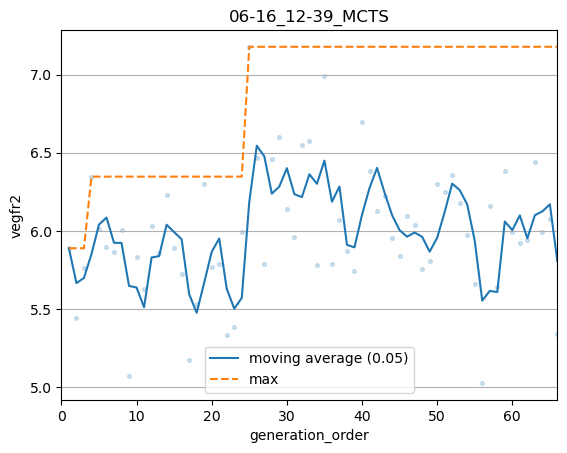

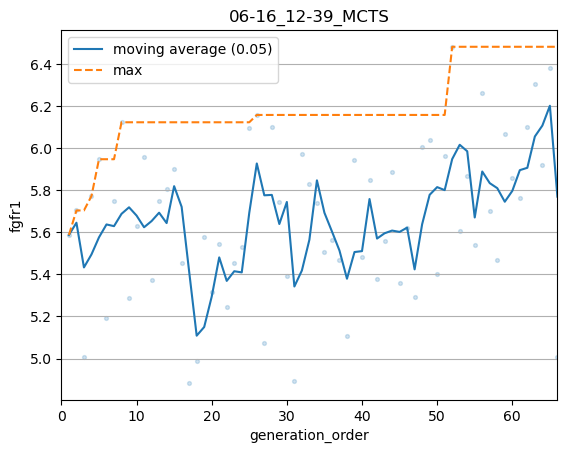

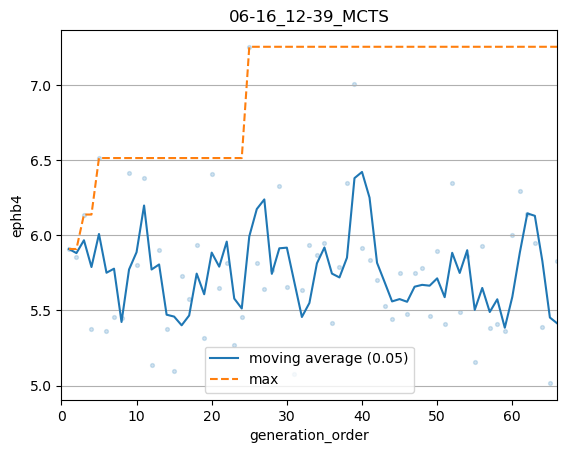

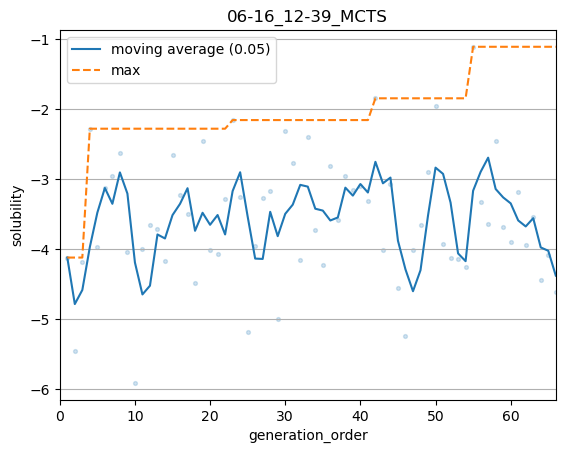

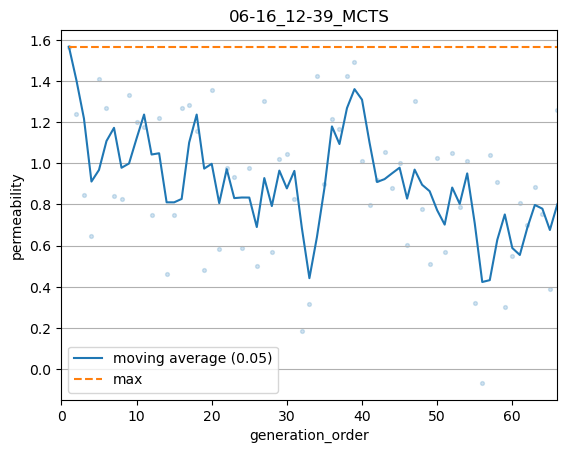

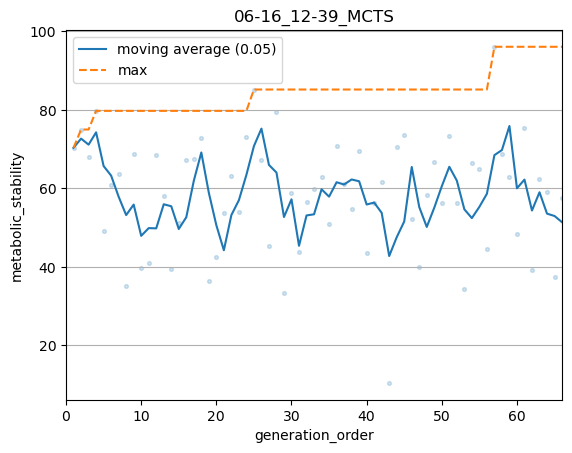

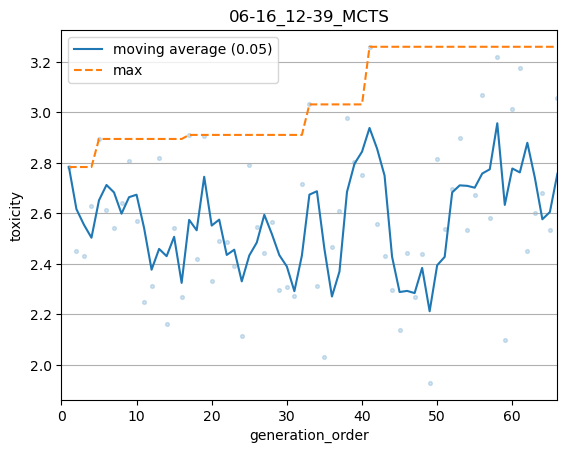

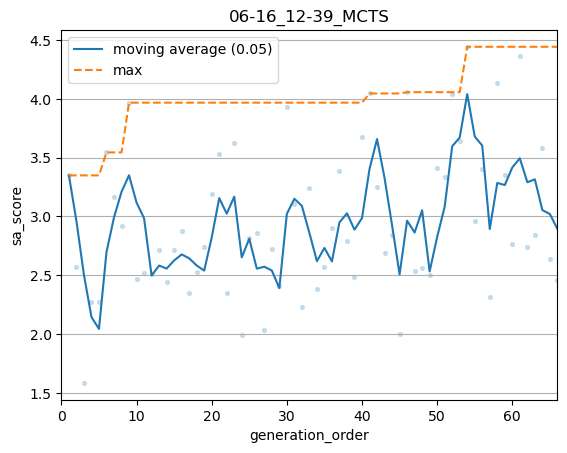

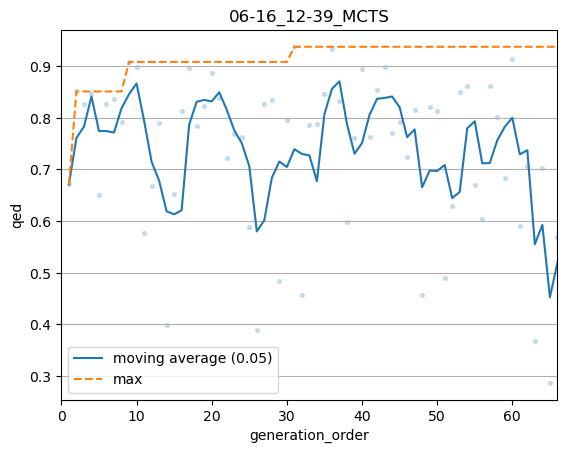

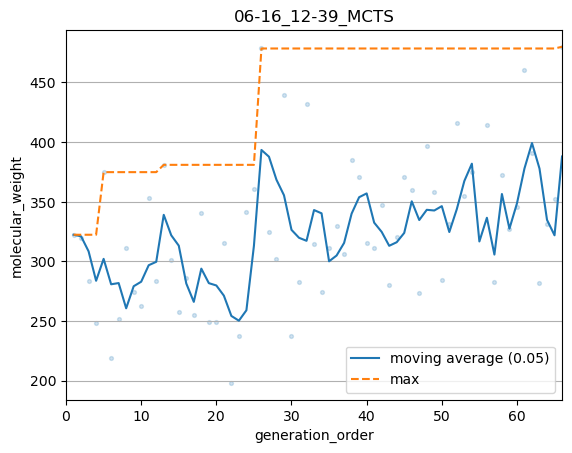

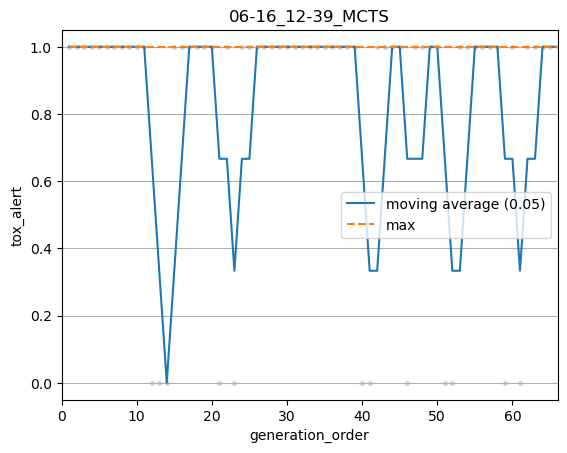

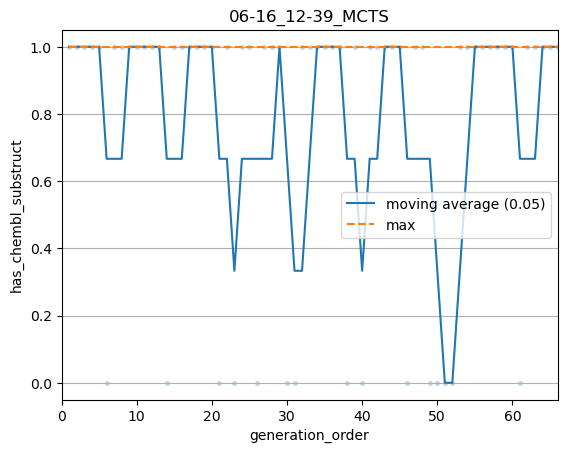

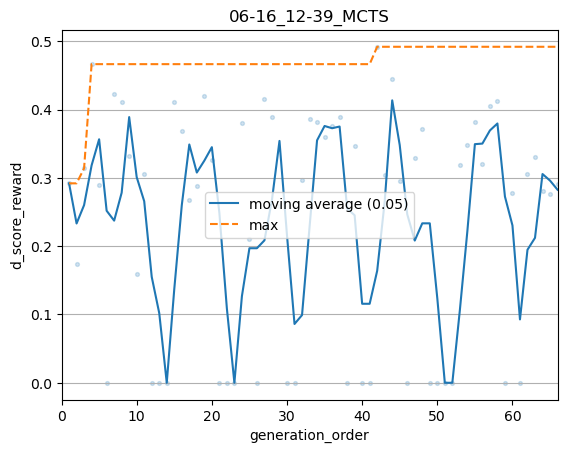

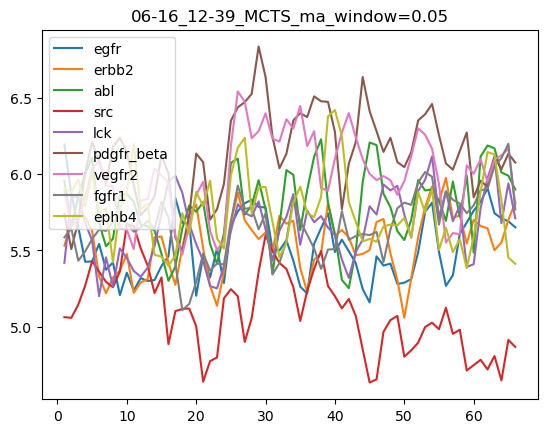

number of generated nodes: 66
valid rate: 0.6285714285714286
unique rate: 1.0
node_per_sec: 6.4218408235035085


In [8]:
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
generator, conf = execute_yaml(c1)
# queue_yaml(c1, c2)

In [ ]:
#continue search
generator.generate(max_generations=10)
generator.plot(**conf.get("plot_conf", {}))
generator.analyze()

In [14]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load mcts test
load_path = generator.output_dir() + "save.mcts"
generator = MCTS.load(load_path, generator.transition) #TODO: separate notebook